# VAE for cifar-10

small proof of concept VAE based on [Kingma and Welling, 2014](https://arxiv.org/abs/1312.6114)

[Transposed convolution visualizations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import itertools
from functools import partial

import matplotlib.pyplot as plt

from importlib import reload

from src import vae as vae_lib
import pickle
import os

In [2]:
torch.has_cuda

True

##  load cifar-10

In [3]:
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
for X, y in trainloader:
    print(X.min(), X.max())
    print(X.shape)
    print(y.shape)
    break

tensor(-1.) tensor(1.)
torch.Size([128, 3, 32, 32])
torch.Size([128])


##  Training

In [6]:
loss_histories_path = './saved_models/loss_histories.pickle'
prefix, ext = os.path.splitext(loss_histories_path)
loss_histories_path_bkup = prefix + '_bkup' + ext
if os.path.exists(loss_histories_path):
    with open(loss_histories_path , 'rb') as f:
        loss_histories = pickle.load(f)
    with open(loss_histories_path_bkup , 'wb') as f:
        pickle.dump(loss_histories, f)
else:
    loss_histories = dict()
loss_histories.keys()

dict_keys(['vae_resent_n5_dmodel64_dz64', 'vae_resent_mixture_n3_x2_dmodel64_dz64', 'vae_resent_n5_dmodel64_dz64_bkup', 'vae_resent_n10_dmodel64_dz64_bkup', 'vae_resent_mixture_n5_x1_dmodel64_dz64'])

In [7]:
try:
    del model
except:
    pass
torch.cuda.memory_allocated()

0

### model config

In [12]:
resnet_n = 5
d_model = 64
d_z = 64
expt_key = f'vae_resent_n{resnet_n}_dmodel{d_model}_dz{d_z}'
print(expt_key)

vae_resent_n5_dmodel64_dz64


### define and init or load model

In [13]:
reload(vae_lib)
model = vae_lib.VAE(resnet_n=resnet_n, d_model=d_model, d_z=d_z)
model_state_path = f'saved_models/{expt_key}/state_final'
if os.path.exists(model_state_path):
    print(f'loading model state at {model_state_path}')
    with open(model_state_path, 'rb') as f:
        model.load_state_dict(torch.load(f))
else:
    print('initializing new model')
    vae_lib.init_xavier(model)

loading model state at saved_models/vae_resent_n5_dmodel64_dz64/state_final


### train model

In [ ]:
reload(vae_lib)
for _ in range(50):
    vae_lib.train_epoch(model,
                        loss_histories,
                        expt_key,
                        device='cuda',
                        train_loader=trainloader,
                        test_loader=testloader,
                        save_state_only=True,
                        eval_every=1e5,
                   )

## training curves

In [14]:
def smooth(arr, window):
    runsum = sum(arr[:window])
    out = [runsum / window]
    i = 0
    j = window

    while j < len(arr):
        runsum -= arr[i]
        runsum += arr[j]
        out.append(runsum / window)
        i += 1
        j += 1

    return out


def plot_loss(xy_pairs, smooth_window=0, **kwargs):
    examples, loss = zip(*xy_pairs)
    if smooth_window > 0:
        loss = smooth(loss, smooth_window)
        examples = examples[:len(loss)]
    plt.plot(examples, loss, **kwargs)

In [15]:
loss_histories.keys()

dict_keys(['vae_resent_n5_dmodel64_dz64', 'vae_resent_mixture_n3_x2_dmodel64_dz64', 'vae_resent_n5_dmodel64_dz64_bkup', 'vae_resent_n10_dmodel64_dz64_bkup', 'vae_resent_mixture_n5_x1_dmodel64_dz64'])

Text(0.5, 1.0, 'vae_resent_n5_dmodel64_dz64')

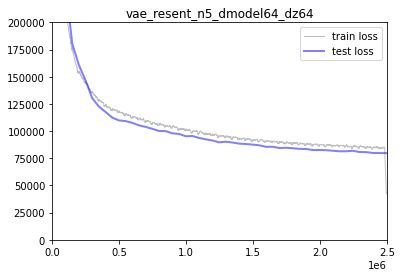

In [23]:
plot_loss(loss_histories['vae_resent_n5_dmodel64_dz64_bkup']['train_loss'],
          smooth_window=50,
          color='gray',
          linewidth=1,
          alpha=.5)
plot_loss(loss_histories['vae_resent_n5_dmodel64_dz64_bkup']['test_loss']['loss'],
          smooth_window=1,
          color='blue',
          linewidth=2,
          alpha=.5)
plt.ylim([0, 2e5])
plt.xlim([0, 2.5e6])
plt.legend(['train loss', 'test loss'])
plt.title('vae_resent_n5_dmodel64_dz64')

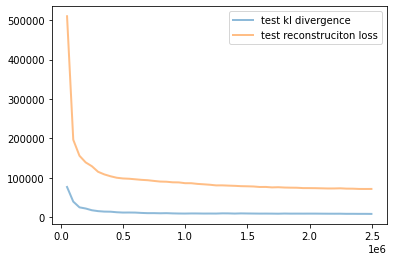

In [24]:
plot_loss(loss_histories['vae_resent_n5_dmodel64_dz64_bkup']['test_loss']['kl'],
          smooth_window=1,
          linewidth=2,
          alpha=.5)
plot_loss(loss_histories['vae_resent_n5_dmodel64_dz64_bkup']['test_loss']['mse'],
          smooth_window=1,
          linewidth=2,
          alpha=.5)
plt.legend(['test kl divergence', 'test reconstruciton loss'])

In [18]:
with open('./saved_models/loss_histories.pickle', 'wb') as f:
    pickle.dump(loss_histories, f)

##  sampling and reconstruction

We see the model is capable of reproducing color and high-level shapes. Likely much more training and hyperparameter tuning is required for it to learn better reconstructions.

In [28]:
def to_numpy_img(tensor):
    return tensor.cpu().detach().numpy()[0, :, :, :].transpose(1, 2, 0)

In [29]:
# grab the first batch in the test set
for X, y in testloader:
    break

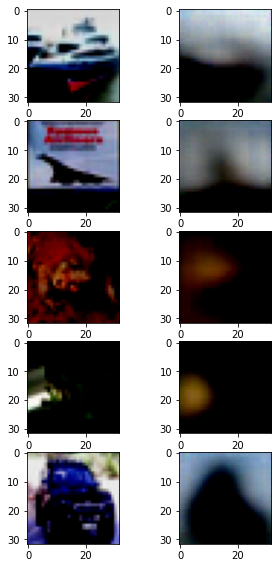

In [30]:
plt.figure(figsize=(5, 20))

model.eval()

for i in range(1, 11, 2):
    img_in = torch.unsqueeze(X[i, :, :, :], 0).to('cuda')
    zu, zs, img_out = model(img_in)
    plt.subplot(10, 2, i)
    plt.imshow(to_numpy_img(img_in))
    plt.subplot(10, 2, i + 1)
    plt.imshow(to_numpy_img(img_out))

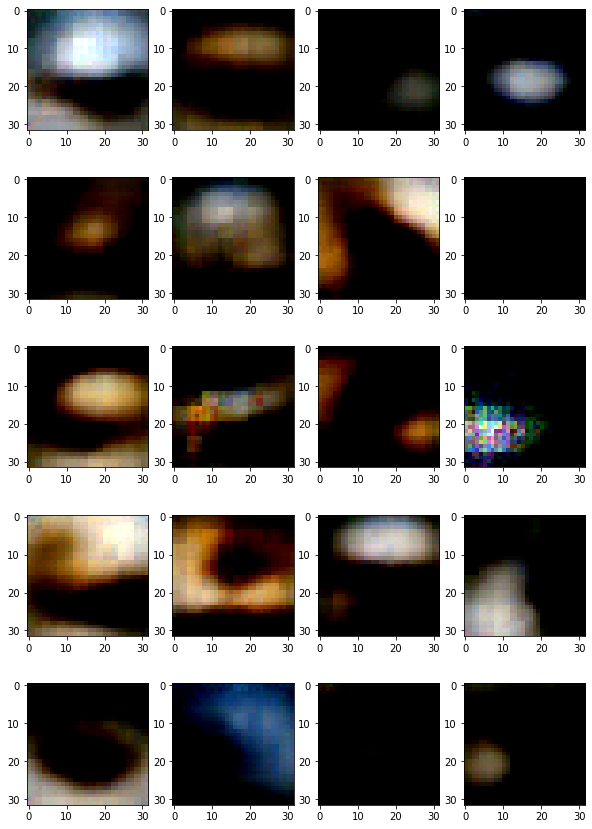

In [59]:
plt.figure(figsize=(10, 15))

model.eval()

for i in range(1, 21):
    plt.subplot(5, 4, i)
    random_img = model.decoder(torch.randn(1, 64, 1, 1).to('cuda'))
    plt.imshow(to_numpy_img(random_img))